#  Monte Carlo Simulations for Stock Price Predictions 

### A Monte Carlo simulation runs an enourmous amount of trials with different random numbers generated from an underlying distribution for the uncertain variables.
Let us try to implement this using one Technical Indicator as a reference for prediction.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_datareader as web
import datetime

import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from yahoo_fin.stock_info import get_data

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [3]:
from datetime import date,timedelta

In [4]:
BSE= get_data("amzn", start_date="12/11/2020", end_date=date.today(), index_as_date = True, interval="1wk")

In [5]:
BSE

,open,high,low,close,adjclose,volume,ticker
2020-12-07,154.449493,157.104996,153.641006,155.820999,155.820999,121898000,AMZN
2020-12-14,157.149994,163.175507,156.300003,160.082504,160.082504,427458000,AMZN
2020-12-21,160.000504,161.348495,158.300003,158.634506,158.634506,195038000,AMZN
2020-12-28,159.699997,167.532501,158.634506,162.846497,162.846497,334524000,AMZN
2021-01-04,163.500000,163.600006,156.557999,159.134995,159.134995,370278000,AMZN
...,...,...,...,...,...,...,...
2024-04-01,180.789993,186.270004,178.380005,185.070007,185.070007,176792100,AMZN
2024-04-08,186.899994,189.770004,182.669998,186.130005,186.130005,190222400,AMZN
2024-04-15,187.429993,188.690002,173.440002,174.630005,174.630005,198977200,AMZN
2024-04-22,176.940002,180.820007,166.320007,179.619995,179.619995,202325700,AMZN


In [114]:
BSE.index

DatetimeIndex(['2020-11-30', '2020-12-07', '2020-12-14', '2020-12-21',
               '2020-12-28', '2021-01-04', '2021-01-11', '2021-01-18',
               '2021-01-25', '2021-02-01',
               ...
               '2024-02-26', '2024-03-04', '2024-03-11', '2024-03-18',
               '2024-03-25', '2024-04-01', '2024-04-08', '2024-04-15',
               '2024-04-22', '2024-04-29'],
              dtype='datetime64[ns]', length=179, freq=None)

In [33]:
#our test data is the last month
train=BSE['close'][:-4]


### Now that we have the data we need to find:

#### Expected_return= "Mean of close till now" (we can use different methods here)
#### Volatility=Standard deviation
#### dt=1/252

Text(13.819444444444445, 0.5, 'Frequency')

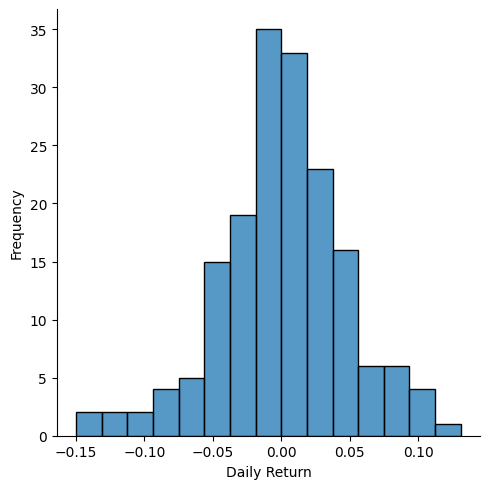

In [34]:
log_returns = np.log(1 + train.pct_change()) # Calculating log of Percent change per day (log is taken to normalize)
sns.displot(log_returns.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [35]:
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)

In [36]:
volatility = np.std(log_returns) * np.sqrt(252)

In [37]:
stdev = log_returns.std()
trials = 1000

S = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

In [38]:
from dateutil import relativedelta
delta = relativedelta.relativedelta(train.index[-1], train.index[0])
decimal_years = delta.years + (delta.months + delta.days/31) / 12
print(f"Decimal years: {decimal_years:.4f}")

Decimal years: 3.3172


In [39]:

num_steps=4
num_paths=1000
dt=decimal_years/num_steps
stock_prices = np.zeros((num_paths, num_steps+1))
stock_prices[:, 0] = train[-1]
# Simulate stock prices
for path in range(num_paths):
        for step in range(1, num_steps + 1):
            # Generate a random return for each step
            random_return = np.random.normal(loc=(drift- 0.5 * volatility ** 2) * dt,
                                             scale=volatility * np.sqrt(dt))
            stock_prices[path, step] = stock_prices[path, step - 1] * np.exp(random_return)
print("Simulated stock prices at the end of the time horizon:")
print(stock_prices[:, 1:])

Simulated stock prices at the end of the time horizon:
[[ 55.9060452   95.33898066 130.01245337 102.31744418]
 [ 79.24658755  93.04831891  34.75742404 112.48496474]
 [ 54.27576582  34.67959032  20.82132622  63.32534681]
 ...
 [ 52.38104051  64.12316852 230.20541035 123.75878507]
 [326.75499728 143.71006589 242.56887443  58.80578634]
 [277.02708998 455.13443353 448.58953492 245.16729843]]


C:\Users\ameya\AppData\Local\Temp\ipykernel_28028\2847059277.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_prices[:, 0] = train[-1]


In [40]:
stock_prices

array([[185.07000732,  55.9060452 ,  95.33898066, 130.01245337,
        102.31744418],
       [185.07000732,  79.24658755,  93.04831891,  34.75742404,
        112.48496474],
       [185.07000732,  54.27576582,  34.67959032,  20.82132622,
         63.32534681],
       ...,
       [185.07000732,  52.38104051,  64.12316852, 230.20541035,
        123.75878507],
       [185.07000732, 326.75499728, 143.71006589, 242.56887443,
         58.80578634],
       [185.07000732, 277.02708998, 455.13443353, 448.58953492,
        245.16729843]])

In [87]:
Sp=pd.DataFrame(stock_prices[:,1:],columns=[f"Week {i+1}" for i in range(num_steps)])
Sp.describe()

,Week 1,Week 2,Week 3,Week 4
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,178.649727,180.737808,182.664312,187.735416
std,149.342946,201.148440,262.009232,357.482669
min,20.009050,5.752526,0.898473,0.623815
25%,89.664100,65.781826,45.129429,33.462921
50%,146.500119,115.921972,99.322662,80.019034
75%,218.963673,221.469611,204.862262,193.266133
max,2438.295555,2503.797859,2882.531610,4981.876693


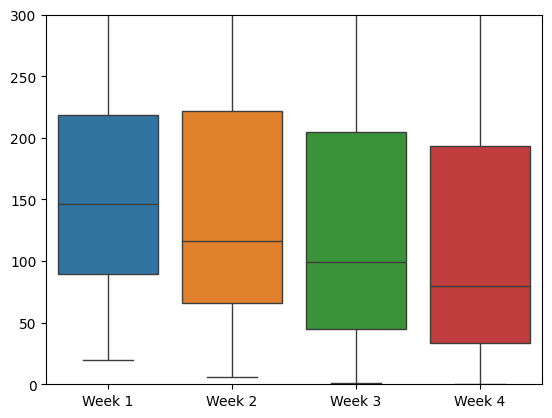

In [108]:
sns.boxplot(Sp)
plt.ylim(0, 300)  # Specify your desired limits here

# Show the plot
plt.show()

In [67]:
BSE['close'][-4:]

2024-04-08    186.130005
2024-04-15    174.630005
2024-04-22    179.619995
2024-04-29    175.000000
Name: close, dtype: float64

Referance links:
https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662
https://pbpython.com/monte-carlo.html